In [2]:
import pandas
import numpy as np

In [3]:
resultsRaw = pandas.read_csv('~/Data/Insight/pricing/test_results.csv')
usersRaw = pandas.read_csv('~/Data/Insight/pricing/user_table.csv')

## AB Testing

In [4]:
from scipy.stats import binom

joinedRaw = pandas.merge(resultsRaw,
                  usersRaw, how='left', 
                  left_on=['user_id'], right_on=['user_id'])

groupA = joinedRaw.iloc[joinedRaw['price'].values==39]
groupB = joinedRaw.iloc[joinedRaw['price'].values==59]

# Check what fraction of users in each group convert
# Compare conversion rates
# Multiply rates by prices to estimate profits for each group

convRateA = float(groupA['converted'].sum())/groupA['converted'].count()
convRateB = float(groupB['converted'].sum())/groupB['converted'].count()
print 'Fraction converted group A: %.4f   Fraction converted group B: %.4f'%(
    convRateA,
    convRateB)

prob = binom.cdf(groupB['converted'].sum(), groupB['converted'].count(), convRateA)
print 'CDF of observing conversion rate B:', prob

Fraction converted group A: 0.0199   Fraction converted group B: 0.0156
CDF of observing conversion rate B: 1.05985021524e-27


The above means that changing the price is having a statistically significant effect on the conversion rate.

Now, does this actually result in a profit...?

In [5]:
'Average profit per user, group A: %.4f   Avg profit per user, group B: %.4f'%(
    convRateA*39, convRateB*59)

'Average profit per user, group A: 0.7757   Avg profit per user, group B: 0.9186'

Yes, we do see a profit, so we should indeed switch everyone to the $59 price point

## Exploratory Data Analysis

In [6]:
import matplotlib.pyplot as plt

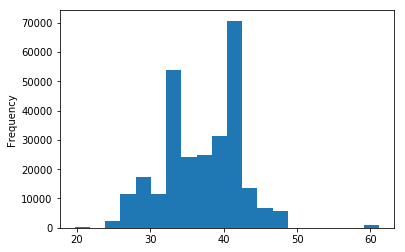

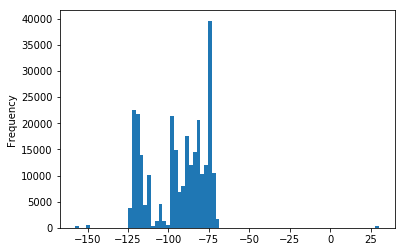

In [7]:
# Look at distribution of latitudes and longitudes 
# Can I manually segment them and turn them into regions?

data = joinedRaw

if False:
    print data
    latest_date = data['timestamp'].max()
    data['filled_dates'] = data['timestamp'].fillna(latest_date)
    pandas.to_datetime(data['filled_dates']).dt.dayofweek

plt.figure()
data['lat'].plot.hist(bins=20)
plt.show()

plt.figure()
data['long'].plot.hist(bins=80)
plt.show()


In [8]:
# Segment into regions
# One hot encode user information

data = joinedRaw

data = pandas.concat([data.iloc[data['converted'].values==1].sample(n=1000), 
                      data.iloc[data['converted'].values==0].sample(n=1000)])

data['long_fill'] = data['long'].fillna(-180)
USeast = data['long_fill'].values > -85
UScent = (data['long_fill'].values <= -85) & (data['long_fill'].values > -100)
USwest = data['long_fill'].values <= -100

data['lat_fill'] = data['lat'].fillna(10)
USnorth = data['lat_fill'].values > 37
USsouth = data['lat_fill'].values <= 37

source = pandas.get_dummies(data['source'])
device = pandas.get_dummies(data['device'])
OSes = pandas.get_dummies(data['operative_system'])

print source.shape, device.shape, OSes.shape, USeast.shape

(2000, 12) (2000, 2) (2000, 6) (2000,)


In [9]:
# Vectorize data

nfeatures = 12+2+6+5

nposts = len(data)
test = ((np.arange(nposts) % 10) == 0) | ((np.arange(nposts) % 10) == 3)
train = np.logical_not(test)
ntrain = len(np.where(train)[0])

if True:
    data_model = np.zeros([nposts,nfeatures])
    data_model[:,0:12] = source.values
    data_model[:,12:14] = device.values
    data_model[:,14:20] = OSes.values
    data_model[:,20] = USeast
    data_model[:,21] = UScent
    data_model[:,22] = USwest
    data_model[:,23] = USnorth
    data_model[:,24] = USsouth
    
    feat_min = []
    feat_max = []
    feat_mean = []
    for i in range(nfeatures):
        feat_min.append(np.min(data_model[:,i]))
        feat_max.append(np.max(data_model[:,i]))
        feat_mean.append(np.mean(data_model[:,i]))
        data_model[:,i] = (data_model[:,i] - feat_mean[i]) / (feat_max[i] - feat_min[i])

    data_train = data_model[train,:]
    data_test = data_model[test,:]
    
    y_model = data['converted'].values
    if False:
        y_min = np.min(y_model)
        y_max = np.max(y_model)
        y_mean = np.mean(y_model)
        y_model = (y_model - y_mean)  / (y_max - y_min)
    y_train = y_model[train]
    y_test = y_model[test]

nposts

2000

96.75


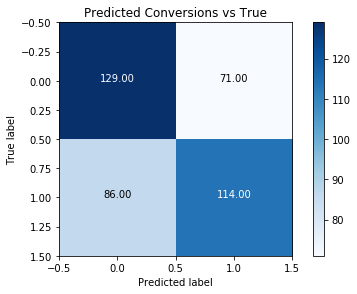

Accuracy: 0.60000   Recall: 0.64500   F1 score: 0.31084 


In [10]:
# Run regression

# Test if certain correlations are consistent and can be used as predictors for conversion rate
    
from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error as MSE, r2_score as R2S, confusion_matrix
import matplotlib.pyplot as plt
import itertools

regr = linear_model.LogisticRegression()
regr.fit(data_train, y_train)

y_pred = regr.predict(data_test)
cm = confusion_matrix(y_test,y_pred)

if True:
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Predicted Conversions vs True')
    plt.colorbar()

    fmt = '.2f' if True else 'd'
    thresh = cm.max() * .75
    print thresh
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color=("white" if (cm[i, j] > thresh) else "black"))

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
accuracy = float(cm[0,0])/(cm[0,0]+cm[1,0])
recall = float(cm[0,0])/(cm[0,0]+cm[0,1])
print "Accuracy: %.5f   Recall: %.5f   F1 score: %.5f "%(accuracy,
                                                    recall,
                                                    accuracy*recall/(accuracy+recall))

In [11]:
# Which features are positively correlated with conversion?

features = list(source.columns.values) + list(device.columns.values) + list(OSes.columns.values) + \
    ['USeast', 'UScent', 'USwest', 'USnorth', 'USsouth']

coefficients = pandas.concat([pandas.DataFrame(features),
                              pandas.DataFrame(np.transpose(regr.coef_))], 
                             axis = 1)
print coefficients

                  0         0
0          ads-bing -0.289128
1        ads-google  0.018838
2         ads-yahoo -0.081080
3      ads_facebook  0.076021
4         ads_other -0.080395
5    direct_traffic -0.362188
6   friend_referral  0.819268
7          seo-bing  0.359920
8        seo-google -0.152361
9         seo-other -0.617381
10        seo-yahoo  0.075619
11     seo_facebook  0.232866
12           mobile  0.198490
13              web -0.198490
14          android -0.286079
15              iOS  0.341270
16            linux -0.842616
17              mac  0.648998
18            other -0.206000
19          windows  0.344425
20           USeast -0.002425
21           UScent -0.034284
22           USwest  0.036709
23          USnorth -0.049772
24          USsouth  0.049772


The features that are positively correlated may be indicators of users who are more likely to convert.
We could carry out further AB test by targeting users with such features and see if we can improve their conversion rate.